
## Course: Data Science for Linguists
## Winter semester 23/24
## Assignment: Project (part 4)
## Student: Alla Savinkina


In [ ]:
!pip install spacy

In [1]:
import ast
import spacy
from collections import defaultdict
import json
import pandas as pd
import string

In [3]:
!python -m spacy download ru_core_news_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 513.4/513.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 72.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
nlp = spacy.load("ru_core_news_lg")

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
cd /content/gdrive/MyDrive/rus_phraseology

/content/gdrive/MyDrive/rus_phraseology


#### 1: process the russian idioms with spacy and save to phrase dict:

In [9]:
def clean_register_string(register_str):
    """
    Cleans the 'register:' string by removing punctuation and splitting
    it into a list of individual registers.
    """
    if register_str.startswith("register:"):
        register_content = register_str[len("register:"):].strip()
        # Remove periods (stops) but keep commas for splitting
        cleaned_content = register_content.translate(str.maketrans("", "", string.punctuation.replace(",", "")))
        return [reg.strip() for reg in cleaned_content.split(",")]
    return [register_str.strip()]

In [10]:
idiom_dict = defaultdict(list)
input_txt = "rus_phraseology_variations.txt"
with open(input_txt, "r", encoding="utf-8") as infile:
    for line in infile:
        if "\t\tregister: " in line:
            phrase, register = line.split("\t\tregister: ", 1)
            cleaned_register = clean_register_string(f"register: {register}")
            doc = nlp(phrase.lower())
            # single-token or expressions
            if len(list(phrase.split())) == 1:
                deps = [(phrase, phrase, "fixed_expr")]
            else:
                deps = [
                    (token.head.lemma_, token.lemma_, token.dep_)
                    for token in doc
                    if token.i != token.head.i
                ]
            # Convert dependencies to a frozenset for order-insensitivity
            idiom_dict[frozenset(deps)].extend(cleaned_register)

In [11]:
for key, value in list(idiom_dict.items())[:5]:
    print(f"Key: {key}, Value: {value}")

Key: frozenset({('быть', 'ли', 'advmod'), ('быть', 'а', 'cc'), ('мальчик', 'быть', 'cop')}), Value: ['ирон']
Key: frozenset({('слушать', 'васька', 'nsubj'), ('слушать', 'есть', 'punct'), ('слушать', 'да', 'obj'), ('слушать', 'а', 'cc')}), Value: ['ирон']
Key: frozenset({('вертеться', 'таки', 'advmod'), ('вертеться', '-', 'advmod'), ('вертеться', 'всё', 'advmod'), ('вертеться', 'и', 'cc'), ('вертеться', 'она', 'nsubj')}), Value: ['книжн']
Key: frozenset({('вертеться', 'таки', 'advmod'), ('вертеться', 'а', 'cc'), ('вертеться', '-', 'advmod'), ('вертеться', 'всё', 'advmod'), ('вертеться', 'она', 'nsubj')}), Value: ['книжн']
Key: frozenset({('открываться', 'просто', 'advmod'), ('открываться', 'ларчик', 'nsubj'), ('открываться', 'а', 'cc')}), Value: ['ирон']


by some reason I always have an empty frozenset key which affects look up and needs to be manually deleted.

In [12]:
if frozenset() in idiom_dict:
    del idiom_dict[frozenset()]
    print("Empty frozenset key deleted from idiom_dict.")
else:
    print("No empty frozenset key found in idiom_dict.")

Empty frozenset key deleted from idiom_dict.


In [13]:
# Extract single-word idioms from idiom_dict(these words do not have dependencies)
single_word_idioms = {
    tuple(next(iter(key)))[0]: registers  # Extract the word and its registers
    for key, registers in idiom_dict.items()
    if len(key) == 1 and tuple(next(iter(key)))[2] == "fixed_expr"
}
print(len(single_word_idioms))

for idiom in single_word_idioms:
      print(idiom)

14
бой-баба
всего-навсего
ей-богу
ёлки-палки
жив-здоров
ищи-свищи
молодо-зелено
перекати-поле
печки-лавочки
пятое-десятое
худо-бедно
шиворот-навыворот
шито-крыто
шуры-муры


#### 2: process movie sentences with spacy and look up the idioms

In [14]:
movies_df = pd.read_csv("subtitles_processed/rus_sub_df.csv")
movies_df.head()

,id,title,genre,text
0,1,100 minutes,"drama, history, war",{1: 'ИВАН ДЕНИСОВИЧ по мотивам рассказа АЛЕКСА...
1,2,12,"crime, drama, thriller, war","{1: '""ДВЕНАДЦАТЬ"" Господа присяжные заседатели..."
2,3,1812. ulanskaya ballada,"adventure, drama, history","{1: '[по-французски] Графиня Валевская, я рад,..."
3,4,"7 dney, 7 nochey","comedy, family",{1: '(Настя) -Давным-давно в одной солнечной с...
4,5,about love,"drama, romance, thriller","{1: 'СУБТИТРЫ: Н.ПЕТРУЛЕВИЧ, И.КИРИК, А.СОЛОНИ..."


In [15]:
movies_df.shape

(303, 4)

warning: execution takes ~ 52 minutes

In [16]:
movies_deps = {}
movies_lemmas = {}  # To store lemmas for single-word idiom lookup

for row_id, text_dict in movies_df["text"].items():
    # Convert string to dictionary if needed
    if isinstance(text_dict, str):
        try:
            text_dict = ast.literal_eval(text_dict)
        except Exception as e:
            print(f"Row {row_id}: Failed to parse text_dict - {e}")
            continue

    if isinstance(text_dict, dict):
        sentence_deps = {}
        sentence_lemmas = {}

        for sentence_id, sentence_text in text_dict.items():
            doc = nlp(sentence_text)

            # Extract dependencies
            deps = [
                (token.head.lemma_, token.lemma_, token.dep_)
                for token in doc
            ]
            sentence_deps[sentence_id] = deps

            # Extract lemmas for single-word idioms
            lemmas = {token.lemma_ for token in doc if not token.is_punct and not token.is_space}
            sentence_lemmas[sentence_id] = lemmas

        # Store both dependencies and lemmas
        movies_deps[row_id] = sentence_deps
        movies_lemmas[row_id] = sentence_lemmas
    else:
        print(f"Unexpected type in 'text' column at Row {row_id}: {type(text_dict)}")


In [17]:
for key, value in list(movies_deps.items())[:5]:
    print(f"Row ID: {key}, Sentences: {value}")

Row ID: 0, Sentences: {1: [('иван', 'иван', 'ROOT'), ('иван', 'денисович', 'nmod'), ('мотив', 'по', 'case'), ('иван', 'мотив', 'nmod'), ('мотив', 'рассказ', 'nmod'), ('рассказ', 'александр', 'nmod'), ('александр', 'солженицын', 'appos'), ('один', '"', 'punct'), ('солженицын', 'один', 'appos'), ('один', 'день', 'appos'), ('один', 'иван', 'appos'), ('один', 'денисович', 'appos'), ('один', '"', 'punct'), ('звучать', '[', 'punct'), ('радио', 'по', 'case'), ('звучать', 'радио', 'obl'), ('мотив', 'звучать', 'parataxis'), ('звучать', 'песня', 'nsubj'), ('язык', 'на', 'case'), ('язык', 'английский', 'amod'), ('песня', 'язык', 'nmod'), ('звучать', '.', 'punct'), ('звучать', ']', 'punct'), ('рассказчик', '[', 'punct'), ('звучать', 'рассказчик', 'parataxis'), ('рассказчик', ':]', 'punct'), ('находиться', '"', 'punct'), ('находиться', 'лагерь', 'nsubj'), ('звучать', 'находиться', 'parataxis'), ('середина', 'в', 'case'), ('находиться', 'середина', 'obl'), ('поле', 'широкий', 'amod'), ('середина', '

In [18]:
for key, value in list(movies_lemmas.items())[:5]:
    print(f"Row ID: {key}, Sentences: {value}")


Row ID: 0, Sentences: {1: {'один', 'английский', 'лес', 'рассказчик', 'широкий', 'звучать', 'поле', 'денисович', 'находиться', 'окружить', 'по', 'радио', 'в', 'александр', 'солженицын', 'мотив', 'рассказ', 'на', 'язык', 'песня', 'день', 'лагерь', 'иван', 'середина'}, 2: {'постройка', 'сюрприз', 'гирлянда', 'в', 'ночной', 'для', 'непосвящённый', 'праздничный', 'электролампа', 'укрывать', 'все', 'ночь', 'превращать', 'барак', 'служебный', 'с'}, 3: {'хельсинки', 'такой', 'пассажир', 'северный', 'самолёт', 'маршрут', 'в', 'запад', 'на', 'или', 'как', 'по', 'ленинград', 'лететь'}, 4: {'не', 'нам', 'туда', 'но'}, 5: {'маршрут', 'другой', 'у', 'нас'}, 6: {'это', 'пушка', 'командир', 'иван', 'старший', 'шухов', 'сержант', 'денисович', 'противотанковый'}, 7: {'шофер', 'призыв', 'машинный', 'механик', 'до', 'тракторный', 'работать', 'станция', 'и'}, 8: {'наталья', 'него', 'жена', 'катя', 'два', 'дочка', 'лизонька', 'год', 'семья', 'любимый', 'зоотехник', 'старший', 'четыре', 'мтс', 'же', 'тот', 

In [19]:
print(len(movies_deps))

303


#### 3: Lookup if there are idioms in the sentences of the movies

In [20]:
film_results = {}

for row_id, sentences in movies_deps.items():
    matching_idioms = []  # To store all matching idioms per film
    register_counts = defaultdict(int)
    idiom_sentences = []  # To store sentence details where idioms are found
    text_dict = ast.literal_eval(movies_df["text"][row_id]) if isinstance(movies_df["text"][row_id], str) else movies_df["text"][row_id]
    sentence_lemmas = movies_lemmas[row_id]  # Retrieve lemmas for the row

    # Iterate through sentences in the current film
    for sentence_id, sentence_deps in sentences.items():
        sentence_text = text_dict[sentence_id]
        sentence_deps_set = frozenset(sentence_deps)

        # Step 1: Lookup for multi-word idioms (dependency-based)
        for idiom_key, registers in idiom_dict.items():
            if idiom_key.issubset(sentence_deps_set):
                matching_idioms.append(idiom_key)  # Add matching idiom
                for register in registers:
                    register_counts[register] += 1
                idiom_sentences.append({
                    "sentence_id": sentence_id,
                    "idiom": idiom_key,
                    "sentence_text": sentence_text
                })

        # Step 2: Lookup for single-word idioms (lemma-based)
        sentence_lemma_set = sentence_lemmas[sentence_id]  # Lemmas for the current sentence
        for lemma, registers in single_word_idioms.items():
            if lemma in sentence_lemma_set:
                matching_idioms.append(frozenset({(lemma, lemma, "fixed_expr")}))  # Add as frozenset for consistency
                for register in registers:
                    register_counts[register] += 1
                idiom_sentences.append({
                    "sentence_id": sentence_id,
                    "idiom": lemma,
                    "sentence_text": sentence_text
                })

    # Store the results for the current film
    film_results[row_id] = {
        "idioms": matching_idioms,
        "register_counts": dict(register_counts),
        "idiom_sentences": idiom_sentences
    }

In [21]:
for row_id, result in list(film_results.items())[:2]:
    print(f"Film {row_id}:")
    print(f"  Matching Idioms: {result['idioms']}")
    print(f"  Register Counts: {result['register_counts']}")
    print(f"  Sentences with Idioms:")
    for idiom_sentence in result["idiom_sentences"]:
        print(f"    Sentence ID: {idiom_sentence['sentence_id']}")
        print(f"    Sentence Text: {idiom_sentence['sentence_text']}")
        print(f"    Idiom: {idiom_sentence['idiom']}")

Film 0:
  Matching Idioms: [frozenset({('день', 'третий', 'amod')}), frozenset({('молитва', 'ваш', 'det')}), frozenset({('так', 'и', 'fixed'), ('быть', 'так', 'advmod')}), frozenset({('голова', 'в', 'case'), ('ветер', 'голова', 'nmod')}), frozenset({('время', 'со', 'case')}), frozenset({('мир', 'весь', 'det')}), frozenset({('так', 'и', 'fixed'), ('быть', 'так', 'advmod')}), frozenset({('плакать', 'тюрьма', 'nsubj')}), frozenset({('лоб', 'в', 'case')}), frozenset({('дружба', 'в', 'case'), ('служба', 'дружба', 'conj'), ('дружба', 'а', 'cc'), ('служба', 'не', 'advmod'), ('служба', 'в', 'case')})]
  Register Counts: {'разг': 12, 'шутл': 1, 'неодобр': 1}
  Sentences with Idioms:
    Sentence ID: 201
    Sentence Text: Оказалось, майор третий день как в госпитале по ранению.
    Idiom: frozenset({('день', 'третий', 'amod')})
    Sentence ID: 275
    Sentence Text: Потому и не сбылось по молитвам вашим.
    Idiom: frozenset({('молитва', 'ваш', 'det')})
    Sentence ID: 299
    Sentence Text: 

#### 4: Count the registers

##### Info about the register meanings in English:

*   "высок": elevated, high
*   "груб": rude
*   "ирон: ironic
*   "книжн": bookish
*   "неодобр": disapproving
*   "одобр": approving
*   "отвлеч": abstract
*    "перен": figurative
*    "презр": contemptuous
* "пренебр": dismissive
* "прост": informal (vernacular)
* "проф": professional
* "разг": colloquial
*  "устар": outdated
* "фольк": folklore
* "шутл": humorous
* "экспрес": expressive


In [22]:
idiom_dict[frozenset({('день', 'третий', 'amod')})]

['разг']

In [23]:
idioms_df = movies_df.copy()
idioms_df["register"] = None  # to store register counts
# Populate the "register" column with register counts from film_results
for row_id, result in film_results.items():
    # Get the register counts for the current film
    register_counts = result["register_counts"]
    # Update the "register" column with register counts as a dictionary
    idioms_df.at[row_id, "register"] = register_counts

print(idioms_df[["genre", "register"]].head())

                         genre  \
0          drama, history, war   
1  crime, drama, thriller, war   
2    adventure, drama, history   
3               comedy, family   
4     drama, romance, thriller   

                                            register  
0              {'разг': 12, 'шутл': 1, 'неодобр': 1}  
1  {'разг': 34, 'книжн': 2, 'неодобр': 12, 'одобр...  
2         {'разг': 10, 'прост': 6, '': 3, 'ирон': 1}  
3  {'разг': 10, 'неодобр': 4, 'устар': 1, 'прост'...  
4                     {'разг': 5, 'прост': 2, '': 2}  


In [24]:
from collections import defaultdict
register_dict = defaultdict(lambda: defaultdict(int))
for _, row in idioms_df.iterrows():
    genres = row["genre"]
    registers = row["register"]

    if isinstance(registers, dict):
        for register, count in registers.items():
            register_dict[genres][register] += count

# Convert defaultdict to a regular dictionary for final output
register_dict = {genre: dict(registers) for genre, registers in register_dict.items()}

In [25]:
print(len(register_dict))
for genre, registers in register_dict.items():
    print(f"{genre}: {registers}")

175
drama, history, war: {'разг': 68, 'шутл': 2, 'неодобр': 6, 'прост': 19, '': 6, 'ирон': 1, 'книжн': 6, 'одобр': 1, 'экспрес': 1, 'пренебр': 1}
crime, drama, thriller, war: {'разг': 34, 'книжн': 2, 'неодобр': 12, 'одобр': 1, 'прост': 2, '': 1, 'пренебр': 1}
adventure, drama, history: {'разг': 10, 'прост': 6, '': 3, 'ирон': 1}
comedy, family: {'разг': 35, 'неодобр': 6, 'устар': 3, 'прост': 7, '': 6, 'шутл': 1, 'книжн': 2, 'пренебр': 1}
drama, romance, thriller: {'разг': 5, 'прост': 2, '': 2}
biography, drama, history, war, romance: {'разг': 5, 'книжн': 1, 'прост': 1, 'неодобр': 2, 'шутл': 1, 'ирон': 1}
history, action, adventure, war: {'прост': 3, 'груб': 1, 'разг': 16, 'экспрес': 1, 'неодобр': 3, 'книжн': 5}
drama, war: {'разг': 80, 'неодобр': 11, 'одобр': 2, 'прост': 19, 'книжн': 1, 'шутл': 2, 'ирон': 2, 'устар': 2, 'пренебр': 1, '': 3}
animation, comedy, musical, family, romance: {'разг': 9, 'экспрес': 1, 'неодобр': 3, 'устар': 1}
biography, drama, history: {'книжн': 4, 'шутл': 1, 

### 5: Lookup the highest frequency for each register

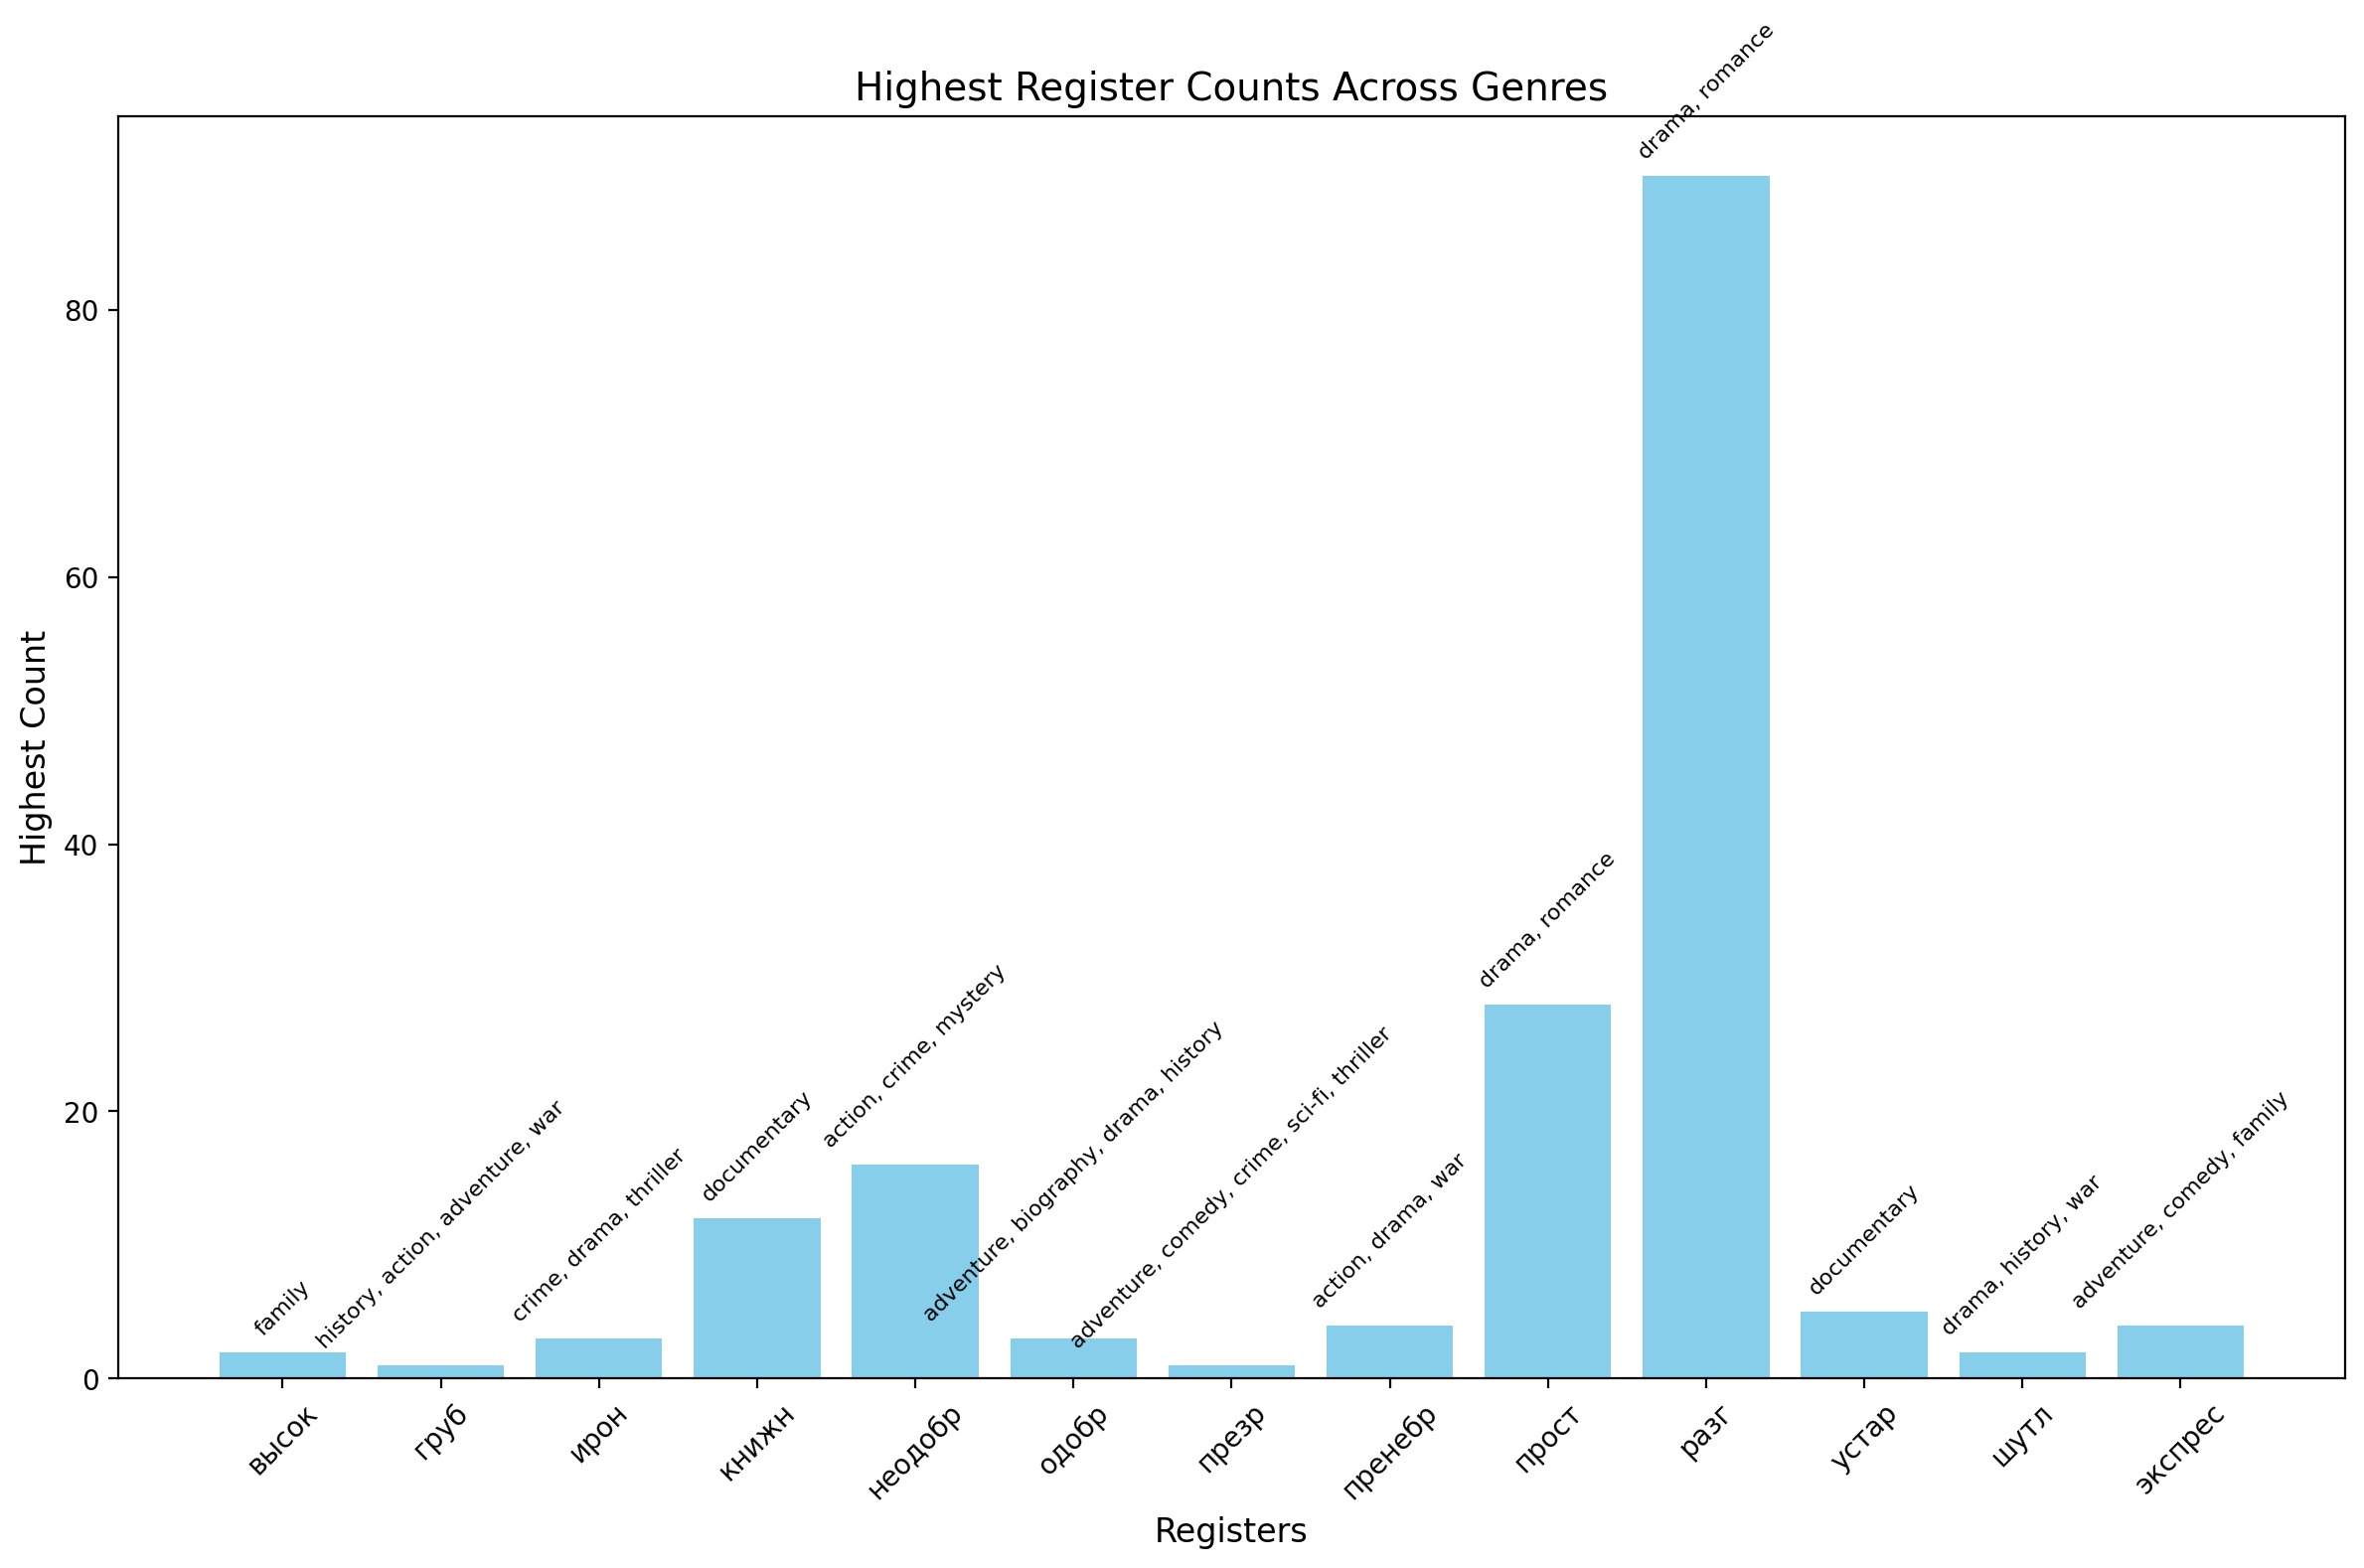

In [26]:
import matplotlib.pyplot as plt

# List of registers to check
genre_list = [
    "высок", "груб", "ирон", "книжн", "неодобр", "одобр",
    "отвлеч", "перен", "презр", "пренебр", "прост", "проф",
    "разг", "устар", "фольк", "шутл", "экспрес"
]

# Prepare data for plotting
registers = []
counts = []
genres = []

# Find the genre with the highest count for each register
for register in genre_list:
    max_genre = None
    max_count = 0

    for genre, registers_data in register_dict.items():
        if register in registers_data and registers_data[register] > max_count:
            max_genre = genre
            max_count = registers_data[register]

    if max_genre:
        registers.append(register)
        counts.append(max_count)
        genres.append(max_genre)

# Plotting
plt.figure(figsize=(12, 8), dpi=200)
plt.bar(registers, counts, color='skyblue')
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Registers', fontsize=12)
plt.ylabel('Highest Count', fontsize=12)
plt.title('Highest Register Counts Across Genres', fontsize=14)

# Annotate bars with genres
for i, genre in enumerate(genres):
    plt.text(i, counts[i] + 1, genre, ha='center', va='bottom', fontsize=8, rotation=45)

plt.tight_layout()
plt.show()


### 6: Filter out the registers higher than 10

In [27]:
# Filter for registers with values greater than 10
filtered_register_dict = {}

for genre, registers in register_dict.items():
    # Filter the registers for the current genre
    filtered_registers = {reg: count for reg, count in registers.items() if count > 10}
    if filtered_registers:  # Only include genres with at least one register > 10
        filtered_register_dict[genre] = filtered_registers


In [28]:
for genre, registers in filtered_register_dict.items():
    print(f"{genre}: {registers}")
print(len(filtered_register_dict))

drama, history, war: {'разг': 68, 'прост': 19}
crime, drama, thriller, war: {'разг': 34, 'неодобр': 12}
comedy, family: {'разг': 35}
history, action, adventure, war: {'разг': 16}
drama, war: {'разг': 80, 'неодобр': 11, 'прост': 19}
biography, drama, history: {'разг': 24}
documentary: {'разг': 51, 'книжн': 12}
action, thriller: {'разг': 20}
drama, action, sci-fi, romance: {'разг': 11}
action, drama, fantasy, thriller, war, sci-fi: {'разг': 12}
adventure, comedy, family: {'разг': 18}
comedy, crime: {'разг': 15}
comedy, drama, romance: {'разг': 29}
action, drama, war: {'разг': 33}
action, drama, history, war: {'разг': 24}
drama, fantasy, romance: {'разг': 17}
crime, mystery: {'разг': 15}
animation: {'разг': 47}
action, sci-fi, thriller: {'разг': 13}
drama, crime, thriller: {'разг': 18}
biography, drama, sport: {'разг': 37}
war: {'разг': 31}
comedy, romance: {'разг': 51, 'прост': 11}
drama, romance: {'разг': 90, 'прост': 28, '': 24, 'неодобр': 14}
biography, drama: {'разг': 37, 'прост': 21

Visualise the filtered registers

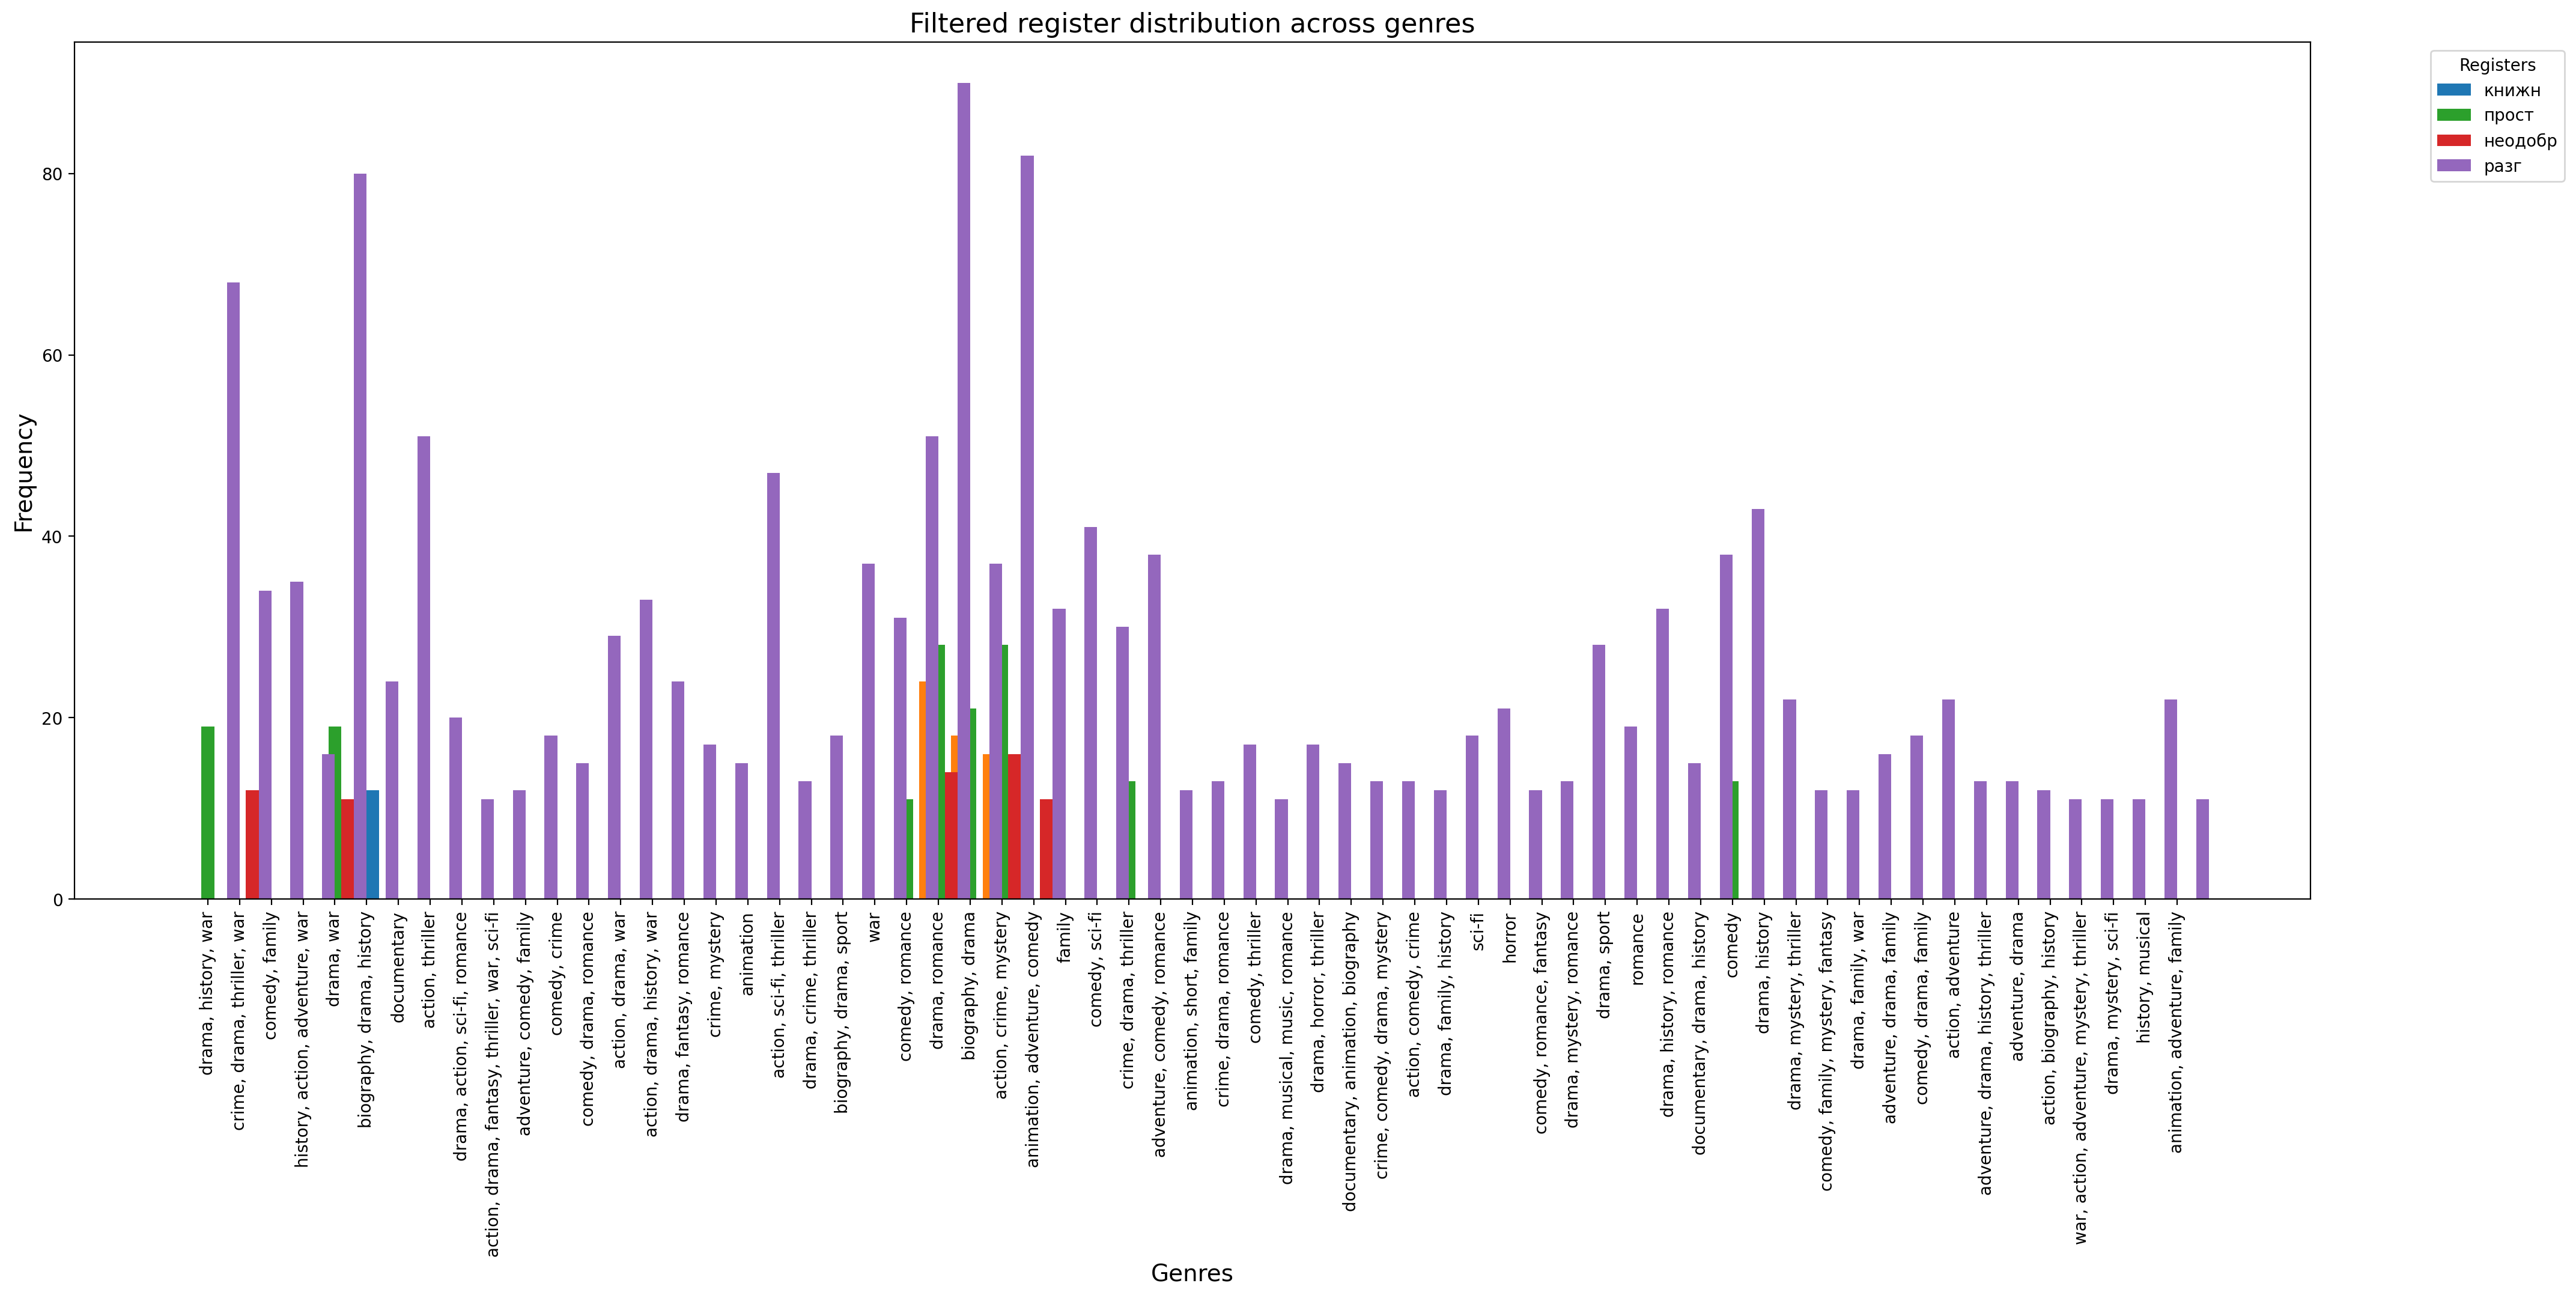

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Extract genres and registers
genres = list(filtered_register_dict.keys())
all_registers = set(key for reg_dict in filtered_register_dict.values() for key in reg_dict.keys())
registers = {reg: [] for reg in all_registers}

# Populate register frequencies
for genre in genres:
    for reg in registers.keys():
        registers[reg].append(filtered_register_dict[genre].get(reg, 0))

# Bar width
bar_width = 0.4  # Thinner bars for better visibility
x = np.arange(len(genres))  # Array for x-axis positions

# Set figure size and resolution
plt.figure(figsize=(22, 12), dpi=200)  # Larger figure size and higher resolution

# Plotting
bar_positions = x - (len(registers) - 1) * bar_width / 2  # Center grouped bars

for i, (reg, values) in enumerate(registers.items()):
    plt.bar(bar_positions + i * bar_width, values, width=bar_width, label=reg)

plt.xticks(x, genres, rotation=90, fontsize=10)
plt.xlabel('Genres', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Filtered register distribution across genres', fontsize=16)
plt.legend(title="Registers", bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout with extra padding
plt.tight_layout(pad=3)
plt.subplots_adjust(bottom=0.35)

plt.show()

### 7: Conclusion:


The "разг" register is overwhelmingly common across most genres, suggesting
that colloquial language is a dominant feature in films regardless of genre.
